# Exctracting information from scanned invoices

Dieses Notebook beschreibt einen möglichen Weg wie man Informationen aus gescannted Rechnung extrahieren kann. Dieser Approach ist vorallem dann sinnvoll, wenn man viele gescannted Rechnung Rechnungen mit gleichem Layout hat.


# Step 1: Import the libraries

### Kovertierung der PDFs in JPEGs
Das Python Modul pdf2image - ein Wrapper für pdftoppm (https://pypi.org/project/pdf2image/) - benötigt eine Poppler Installation

### OCR-Engine
Das Python Modul pytesseract - ein Wrapper für Google’s Tesseract-OCR Engine (https://pypi.org/project/pytesseract/) - benötigt eine Google Tesseract OCR Installation

In [1]:
import pytesseract
import pandas as pd
import numpy as np
import re
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import Levenshtein

pytesseract.pytesseract.tesseract_cmd=r"C:\DEV\tesseract\tesseract.exe"
poppler_dir=r"C:\Program Files\poppler\poppler-0.68.0\bin"

# Step 2: Convert pdf to jpeg

Für diesen Schritt verwendet wir pdf2image ein Wrapper für pdftoppm

In [2]:
pages = convert_from_path("scanned_invoice.pdf", 
                        300, 
                        poppler_path = poppler_dir, 
                        fmt='jpeg')
img=pages[0]

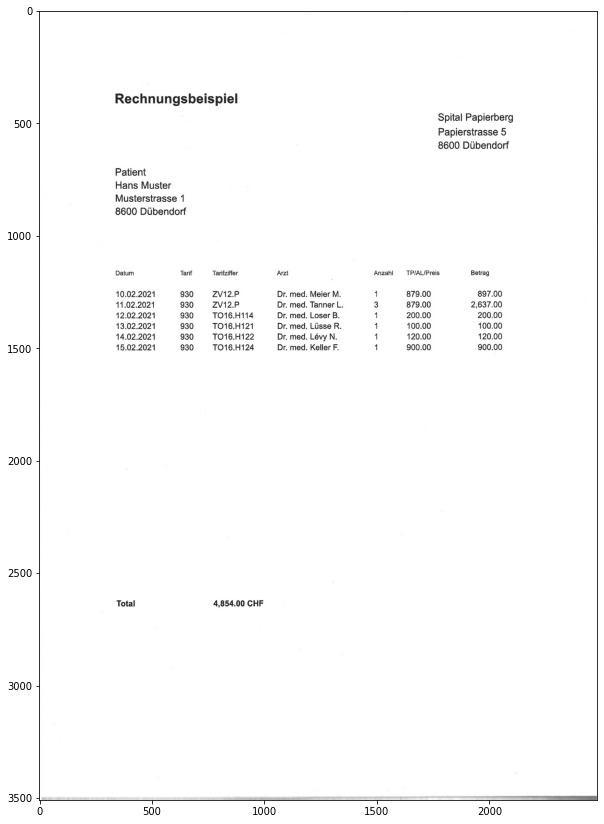

In [3]:
plt.figure(figsize=(10,20))
plt.imshow(img)

# Step 3: Apply OCR Engine to the image

In diesem Schritt verwenden pytesseract ein Wrapper für Google’s Tesseract-OCR Engine. Wir estellen aus dem JPEG Bild eine Tabelle mit den erkannten Texten und deren Positionen.

### Page segmentation method  (--psm)

  0  -  Orientation and script detection (OSD) only.<br>
  1  -  Automatic page segmentation with OSD.<br>
  2  -  Automatic page segmentation, but no OSD, or OCR.<br>
  3  -  Fully automatic page segmentation, but no OSD. (Default)<br>
  4  -  Assume a single column of text of variable sizes.<br>
  5  -  Assume a single uniform block of vertically aligned text.<br>
  6  -  Assume a single uniform block of text.<br>
  7  -  Treat the image as a single text line.<br>
  8  -  Treat the image as a single word.<br>
  9  -  Treat the image as a single word in a circle.<br>
 10  -  Treat the image as a single character.<br>
 11  -  Sparse text. Find as much text as possible in no particular order.<br>
 12  -  Sparse text with OSD.<br>
 13  -  Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.<br>
 
 
 ### OCR Engine modes (--oem)

  0  -  Legacy engine only.<br>
  1  -  Neural nets LSTM engine only.<br>
  2  -  Legacy + LSTM engines.<br>
  3  -  Default, based on what is available.<br>
 

In [6]:
df=pytesseract.image_to_data(img, 
                             output_type='data.frame', 
                             config = r'--oem 1 --psm 6 -l deu')
df.dropna(subset = ["text"], inplace=True)
df.sort_values(by=['left','top'], inplace=True)
df.head(60)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
4,5,1,1,1,1,1,340,366,542,57,90,Rechnungsbeispiel
23,5,1,1,1,8,1,340,874,95,33,96,8600
15,5,1,1,1,5,1,341,699,134,34,96,Patient
17,5,1,1,1,6,1,341,758,98,33,96,Hans
20,5,1,1,1,7,1,341,816,272,33,92,Musterstrasse
26,5,1,1,1,9,1,341,1155,80,21,96,Datum
34,5,1,1,1,10,1,343,1245,171,28,96,10.02.2021
45,5,1,1,1,11,1,343,1292,168,28,94,11.02.2021
56,5,1,1,1,12,1,344,1340,170,27,96,12.02.2021
67,5,1,1,1,13,1,344,1387,171,28,96,13.02.2021


# Step 4: Indentify Invoice line by dates

Wir benutzen die Daten auf der linken Seite der Rechnung um eine Rechungsposition zu identifizieren, dammit wir anschliessend die gesuchten Werte durch ihre relative Position zum Datum finden können. Wir verwenden also das Datum als Ankerpunkt.

In [7]:
def find_dates(df, max_left):
    d_format=r'^([0-2][0-9]|(3)[0-1])(\.)(((0)[0-9])|((1)[0-2]))(\.)\d{4}$'
    ind_date=df['text'].apply(lambda x: True if re.match(d_format, x) else False)
    ind_left=df['left']<max_left
    ind_ret=ind_left&ind_date
    return df['top'][ind_ret].tolist(), df['left'][ind_ret].tolist(), df['text'][ind_ret].tolist()

In [8]:
d_top, d_left, dates = find_dates(df, 400)
print(d_top, d_left, dates, sep='\n')

[1245, 1292, 1340, 1387, 1434, 1482]
[343, 343, 344, 344, 344, 344]
['10.02.2021', '11.02.2021', '12.02.2021', '13.02.2021', '14.02.2021', '15.02.2021']


# Step 5: Find corresponding values using their relative position

Um nun die dazugehörigen Werte einer Rechnungsposition zu finden, können wir die relative Position zum Ankerpunkt verwenden. Zusätzlich definieren wir noch Toleranzen. Dadurch können wir die Felder auch noch finden, wenn die dokumente nicht immer genau gleich eingescannt wurden

In [9]:
def find_ind_value(df_series, pos, tol):
    ind = (df_series > pos - tol) & (df_series < pos + tol)
    return ind

def find_value(df, top, left, tol_top=20, tol_left=60):
    ind_top = find_ind_value(df['top'], top, tol_top)
    ind_left = find_ind_value(df['left'], left, tol_left)
    value = ' '.join(df['text'][ind_top & ind_left].values)
    return value

Dann muss man noch die relative Distanz zwischen den Daten und dem gesuchten Werten bestimmen. 

In [10]:
offset_tarifziffer = 429
offset_arzt = 863
offset_betrag = 1579


Okay dann testen wir einmal ob das funktioniert..

In [11]:
print(find_value(df, 
           d_top[0], 
           d_left[0] + offset_tarifziffer))
print(find_value(df, 
           d_top[0], 
           d_left[0] + offset_betrag))
print(find_value(df, 
           d_top[0], 
           d_left[0] + offset_arzt,
           tol_left=150))

ZV12.P
897.00
Dr. med. Meier M.


Hier gehen wir durch alle Rechnungspositionen durch und speichern die gesuchten Werte ab.

In [12]:
ziffern=[]
betraege=[]
aerzte=[]

for it in range(len(dates)):
    ziffern.append(find_value(df, 
           d_top[it], 
           d_left[it] + offset_tarifziffer))
    betraege.append(find_value(df, 
           d_top[it], 
           d_left[it] + offset_betrag))
    aerzte.append(find_value(df, 
           d_top[it], 
           d_left[it] + offset_arzt,
           tol_left=150))
print(ziffern, betraege, aerzte, sep= '\n')

['ZV12.P', 'ZV12.P', 'TO16.H114', 'TO16.H121', 'TO16.H122', 'TO16.H124']
['897.00', '2,637.00', '200.00', '100.00', '120.00', '900.00']
['Dr. med. Meier M.', 'Dr. med. Tanner L.', 'Dr. med. Loser B.', 'Dr. med. Lüsse R.', 'Dr. med. Levy N.', 'Dr. med. Keller F,']


# Step 6: Create a table containing the data

In [13]:
cols = ['Datum', 'Tarifziffer', 'Arzt', 'Betrag']
data = list(zip(dates, ziffern, aerzte, betraege))

out =  pd.DataFrame(data, columns=cols)
out.head(6)


,Datum,Tarifziffer,Arzt,Betrag
0,10.02.2021,ZV12.P,Dr. med. Meier M.,897.00
1,11.02.2021,ZV12.P,Dr. med. Tanner L.,"2,637.00"
2,12.02.2021,TO16.H114,Dr. med. Loser B.,200.00
3,13.02.2021,TO16.H121,Dr. med. Lüsse R.,100.00
4,14.02.2021,TO16.H122,Dr. med. Levy N.,120.00
5,15.02.2021,TO16.H124,"Dr. med. Keller F,",900.00


# Step 7: Correct categorical data

In [14]:
Levenshtein.distance('Hello World', 'Hello Wrold')

2

In [15]:
arzt_liste = ['Dr. med. Meier M.',
            'Dr. med. Tanner L.',
            'Dr. med. Loser B.',
            'Dr. med. Lüsse R.',
            'Dr. med. Lévy N.',
            'Dr. med. Keller F.']

In [16]:
def find_best_match(str1, options):
    min_distance=np.inf
    match=''
    for elem in options:    
        distance=Levenshtein.distance(str1, elem)
        if distance<min_distance:
            min_distance=distance
            match = elem
            if distance==0:
                return match
    return match

In [17]:
best_matches=out['Arzt'].apply(lambda x: find_best_match(x, arzt_liste))
best_matches

0     Dr. med. Meier M.
1    Dr. med. Tanner L.
2     Dr. med. Loser B.
3     Dr. med. Lüsse R.
4      Dr. med. Lévy N.
5    Dr. med. Keller F.
Name: Arzt, dtype: object

In [18]:
out['Arzt']=best_matches